# UFO Data Preprocessing Notebook 🚀👽🏰

[!WARNING]  
Download the data before running this notebook. Check the documentation.

## Data Loading 📥

In this cell, we load the UFO raw dataset:

- **UFO Data:** Loaded from a CSV file.

In [3]:
import pandas as pd
import numpy as np
import os

# ============================================================
# SETUP: Define output directory relative to this script
# ============================================================
# Get the absolute path of the directory where this script is located
# In a notebook, __file__ is not defined so we use os.getcwd() as a fallback.
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_DIR = os.getcwd()

# Define the folder where raw data is stored (assumed to be "../data/raw")
RAW_DIR = os.path.join(BASE_DIR, "..", "data", "raw")

# Define the folder where processed data will be saved (assumed to be "../data/processed")
PROCESSED_DIR = os.path.join(BASE_DIR, "..", "data", "processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)  # Create the folder if it doesn't exist


# Build the absolute paths for ufo reports
ufo_path = os.path.join(RAW_DIR, "nuforc_reports.csv")

# Load UFO data from CSV using the absolute path
ufo_df = pd.read_csv(ufo_path)

print("✅ Dataset loaded!")

print(ufo_df.head())

print(ufo_df.shape)

✅ Dataset loaded!
           datetime           city state country    shape  \
0  01/02/1950 00:00  New York City    NY     USA     Oval   
1  01/01/1950 22:00     Mount Hope    WV     USA  Unknown   
2  03/22/1950 00:00        Roswell    NM     USA      NaN   
3  04/25/1950 16:00      Vancouver    BC  Canada     Cone   
4  04/15/1950 14:00  Waynesborough    VA     USA     Disk   

                                             summary  
0  good and true info.\n\n 500 Lights On Object0:...  
1            One of first sightings in U.S. -- 1950s  
2  Link to declassified, redacted, USAF document ...  
3  Flying cone-shaped UFO seen by Vancouver airpo...  
4  Fishburne Military School:  9 students witness...  
(149958, 6)


## Filtering UFO Data

This cell filters the UFO dataset by removing rows missing city, state, and country information. We also remove line breaks and multiple spaces.

In [4]:
# Drop rows that have missing values in 'city', 'state', and 'country'
ufo_df.dropna(subset=['city', 'state', 'country'], how='all', inplace=True)

print("Rows with missing values in 'city', 'state', and 'country' dropped!")

# Removes line breaks from DataFrame and add one space
ufo_df = ufo_df.replace(r'\n',' ', regex=True)

# Removes multiple spaces from DataFrame and add one space
ufo_df = ufo_df.replace(r'\s+', ' ', regex=True)

print("All line breaks and multiple blank spaces removed!")

print(ufo_df.head())

Rows with missing values in 'city', 'state', and 'country' dropped!
All line breaks and multiple blank spaces removed!
           datetime           city state country    shape  \
0  01/02/1950 00:00  New York City    NY     USA     Oval   
1  01/01/1950 22:00     Mount Hope    WV     USA  Unknown   
2  03/22/1950 00:00        Roswell    NM     USA      NaN   
3  04/25/1950 16:00      Vancouver    BC  Canada     Cone   
4  04/15/1950 14:00  Waynesborough    VA     USA     Disk   

                                             summary  
0     good and true info. 500 Lights On Object0: Yes  
1            One of first sightings in U.S. -- 1950s  
2  Link to declassified, redacted, USAF document ...  
3  Flying cone-shaped UFO seen by Vancouver airpo...  
4  Fishburne Military School: 9 students witness ...  


## Geocoding UFO Report Locations 🌍

We use the geopy library to obtain geographic coordinates (latitude and longitude) for each UFO report based on its city, state, and country.

- **Nominatim** is used as the geocoder.
- **RateLimiter** is applied to avoid hitting the request limit.

[!WARNING]  
I won't be displaying the output for the next **two** cels since it is too long and it takes too much time to run.

In [ ]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Initialize the Nominatim geocoder with a custom user agent
geolocator = Nominatim(user_agent="ufo_project")
# Use RateLimiter to ensure at least one second delay between geocoding calls
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_coordinates(row):
    """
    Converts a location (city, state, country) into geographic coordinates (latitude, longitude).

    Parameters:
        row (pd.Series): A row from a DataFrame containing 'city', 'state', and 'country' columns.

    Returns:
        tuple: A tuple containing latitude and longitude as floats. If the location cannot be found,
               returns (np.nan, np.nan) to indicate missing data.

    Process:
        - Constructs a location string from the city, state, and country fields in the row.
        - Uses the Nominatim geocoder (via RateLimiter) to query the coordinates for the location.
        - Handles cases where the geocoder cannot find a match by returning NaN values.
        - Prints the geocoding result for debugging purposes.
    """
    # Construct the location string from city, state, and country
    location = geocode(f"{row['city']}, {row['state']}, {row['country']}")
    print(location)  # Debug: print the location result
    if location:
        return location.latitude, location.longitude
    else:
        return np.nan, np.nan  # Return NaN if no location is found

# Apply the geocoding function to each row and create new columns for latitude and longitude
ufo_df[["latitude", "longitude"]] = ufo_df.apply(get_coordinates, axis=1, result_type="expand")

print("UFO data updated with lat/lon! 📍")

print(ufo_df.head())

## Saving the Processed UFO Data 💾

In [ ]:
# Build the absolute path for the output file
ufo_processed_path = os.path.join(PROCESSED_DIR, "ufo_processed.csv")

# Save the processed UFO data to a CSV file in the processed data folder
ufo_df.to_csv(ufo_processed_path, index=False)

print("💾 Saved processed UFO dataset!")

print(ufo_df.head())

print(ufo_df.shape)

## Making Some Preliminar Analysis on the Processed UFO Data 📉

In [43]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

# Convert the 'datetime' column to a pandas datetime object.
ufo_df['datetime'] = pd.to_datetime(ufo_df['datetime'], format="%m/%d/%Y %H:%M")

## Visualizing the Total Timespan of the Data ⏰

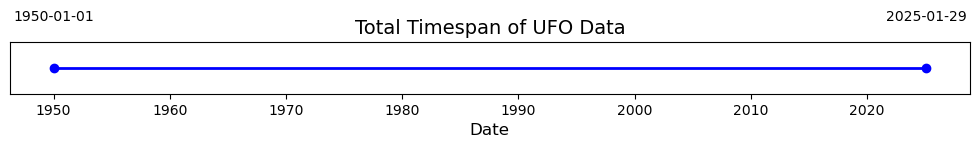

In [44]:
# Create a simple timeline plot showing the earliest and latest record dates.
min_date = ufo_df['datetime'].min()
max_date = ufo_df['datetime'].max()

fig, ax = plt.subplots(figsize=(10, 2))
ax.plot([min_date, max_date], [0, 0], marker='o', color='blue', linewidth=2)
ax.set_title("Total Timespan of UFO Data", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
# Remove y-axis since it's not needed for a timeline
ax.get_yaxis().set_visible(False)
# Annotate the minimum and maximum dates
ax.text(min_date, 0.1, min_date.strftime("%Y-%m-%d"), ha='center', fontsize=10)
ax.text(max_date, 0.1, max_date.strftime("%Y-%m-%d"), ha='center', fontsize=10)
plt.tight_layout()
plt.show()

## Visualizing the Number of Records Missing Latitude or Longitude📍

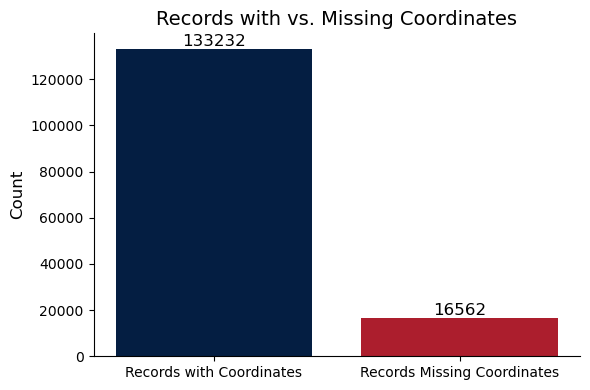

In [45]:
# Create a boolean series indicating rows missing either 'latitude' or 'longitude'
missing_coords = ufo_df['latitude'].isna() | ufo_df['longitude'].isna()
num_missing = missing_coords.sum()
num_available = len(ufo_df) - num_missing

# Define custom colors for the bars
colors = ['#041E42', '#ac1e2d']

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(["Records with Coordinates", "Records Missing Coordinates"],
              [num_available, num_missing],
              color=colors)

# Annotate each bar with its exact value
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: top of the bar
        f'{int(height)}',                  # label text: the exact value
        ha='center',                       # horizontal alignment
        va='bottom',                       # vertical alignment
        fontsize=12,                       # font size for the label
        color='black'                      # text color
    )

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title("Records with vs. Missing Coordinates", fontsize=14)
ax.set_ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

## Number of Records by Country 🌎

In [51]:
# Count the number of records for each country
country_counts = ufo_df['country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Number of Records']
print("Number of Records by Country:")
print(country_counts)

Number of Records by Country:
                 Country  Number of Records
0                    USA             133191
1                 Canada               5935
2         United Kingdom               3581
3              Australia                992
4                  India                514
..                   ...                ...
376  Grand Cayman Island                  1
377         Regatul Unit                  1
378                Norge                  1
379      Tenerife, Spain                  1
380               Rwanda                  1

[381 rows x 2 columns]


## World Map With All Records That Have Latitude and Longitude 🌎

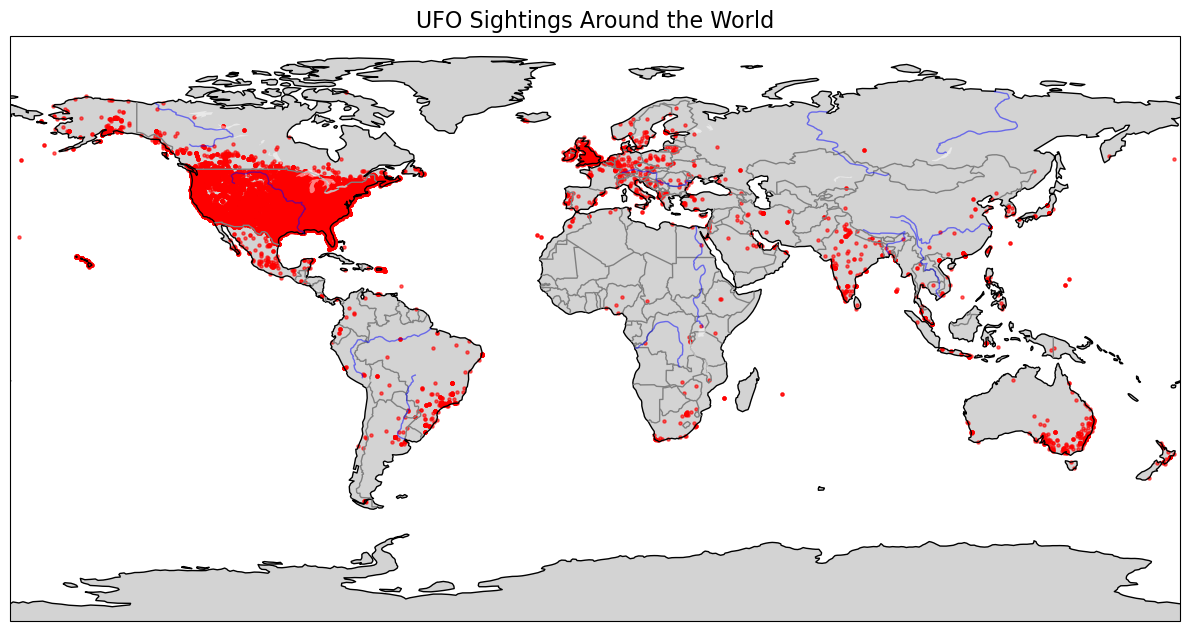

In [47]:
# Filter out rows missing latitude or longitude
df_coords = ufo_df.dropna(subset=['latitude', 'longitude'])

# Create a static world map using Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the map to display the entire globe
ax.set_global()

# Add natural earth features for context
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor='gray')
ax.add_feature(cfeature.LAKES, facecolor='white', alpha=0.5)
ax.add_feature(cfeature.RIVERS, edgecolor='blue', alpha=0.5)

# Overlay UFO sightings on the map
# Plot the UFO sightings as red dots
ax.scatter(df_coords['longitude'], df_coords['latitude'],
           s=5, color='red', alpha=0.6,
           transform=ccrs.PlateCarree())

# Set a title for the map
ax.set_title("UFO Sightings Around the World", fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()

## Cumulative Number of Records Per Day and Decades 📉

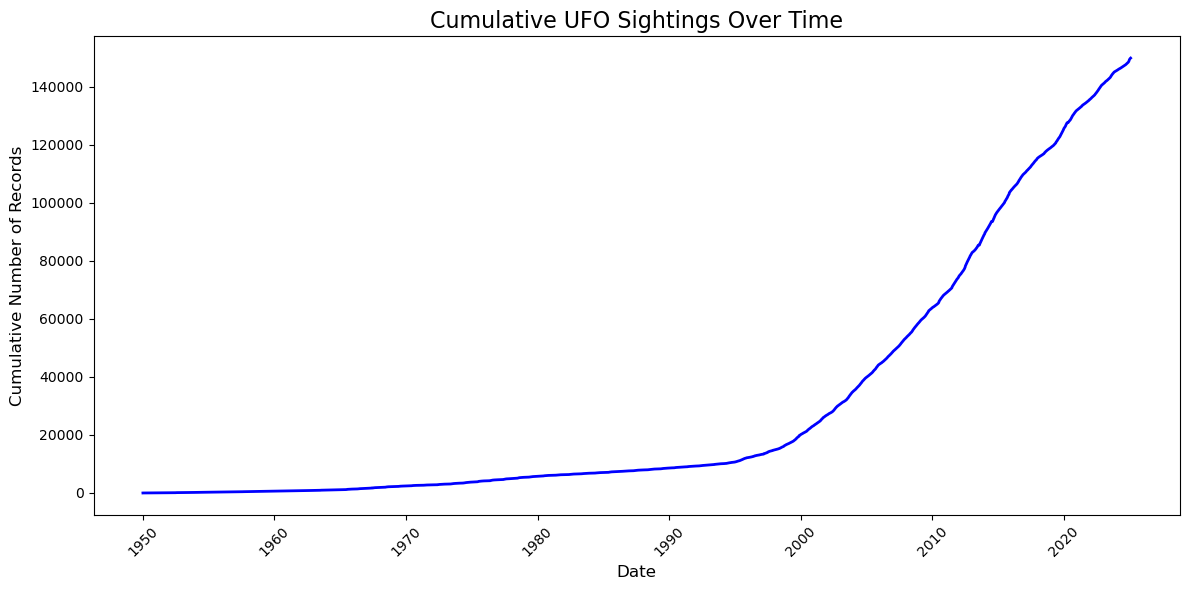

In [48]:
# Create a new column with only the date part (dropping the time)
ufo_df['date'] = ufo_df['datetime'].dt.date

# Group by the 'date' and count the number of records per day
daily_counts = ufo_df.groupby('date').size().reset_index(name='count')
# Sort by date to ensure proper time series order
daily_counts = daily_counts.sort_values('date')
# Calculate the cumulative count
daily_counts['cumulative'] = daily_counts['count'].cumsum()

# Plot the cumulative time series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_counts['date'], daily_counts['cumulative'], color='blue', linewidth=2)
ax.set_title("Cumulative UFO Sightings Over Time", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Cumulative Number of Records", fontsize=12)
# Rotate date labels for clarity
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

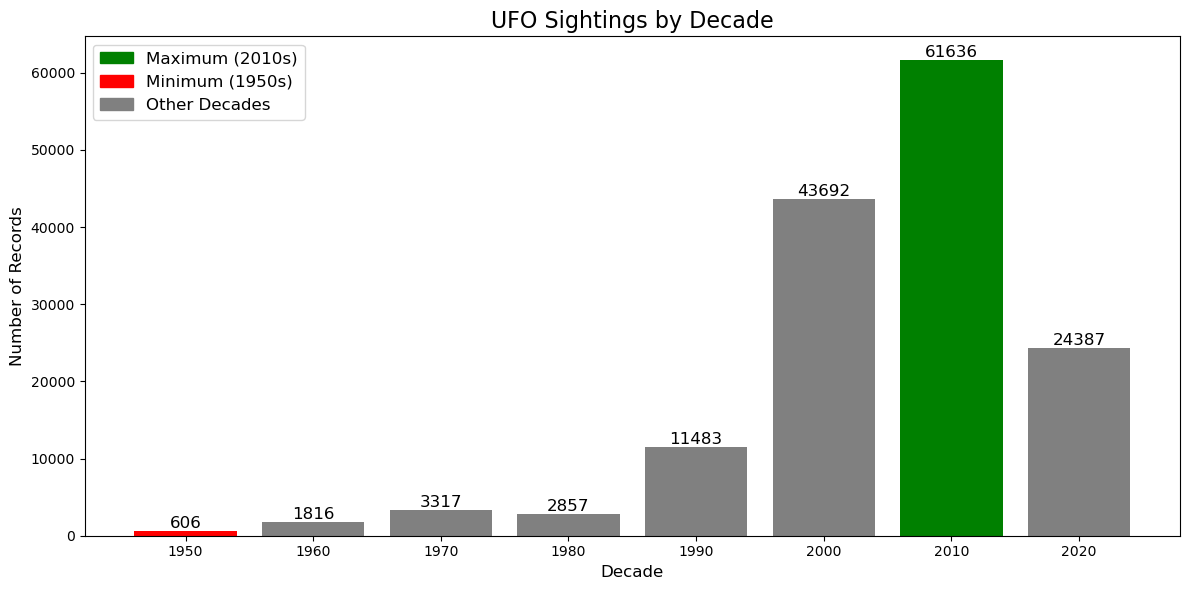

In [49]:
# Create a Decade Column
# Extract the year and then compute the decade (e.g., 1950 for any year between 1950 and 1959)
ufo_df['year'] = ufo_df['datetime'].dt.year
ufo_df['decade'] = (ufo_df['year'] // 10) * 10

# Group by Decade and Count Records
# This gives the total number of UFO records for each decade
decade_counts = ufo_df.groupby('decade').size().reset_index(name='count')

# Identify the Maximum and Minimum Decades
max_decade = decade_counts.loc[decade_counts['count'].idxmax(), 'decade']
min_decade = decade_counts.loc[decade_counts['count'].idxmin(), 'decade']

# Set Colors for the Bars
# Use green for the decade with the most records, red for the one with the fewest,
# and gray for the remaining decades.
colors = []
for d in decade_counts['decade']:
    if d == max_decade:
        colors.append('green')
    elif d == min_decade:
        colors.append('red')
    else:
        colors.append('gray')

# Plot the Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(decade_counts['decade'].astype(str), decade_counts['count'], color=colors)

ax.set_title("UFO Sightings by Decade", fontsize=16)
ax.set_xlabel("Decade", fontsize=12)
ax.set_ylabel("Number of Records", fontsize=12)

# Annotate each bar with its exact value
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: top of the bar
        f'{int(height)}',                  # label: the number of records
        ha='center', va='bottom', fontsize=12
    )

# Create custom legend handles
max_patch = mpatches.Patch(color='green', label=f'Maximum ({max_decade}s)')
min_patch = mpatches.Patch(color='red', label=f'Minimum ({min_decade}s)')
other_patch = mpatches.Patch(color='gray', label='Other Decades')

ax.legend(handles=[max_patch, min_patch, other_patch], fontsize=12)

plt.tight_layout()
plt.show()